In [1660]:
import numpy as np
import fileinput
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy import linalg as sLA
from scipy.spatial import distance as distance
from scipy import stats
from collections import defaultdict

Replace categorical variables in dataset to corresponding vector values. Then download data to datanp variable.

In [1002]:
with fileinput.FileInput('abalone-beta.txt', inplace=True) as file:
    for line in file:
        print(line.replace('M', '1,0,0').replace('F', '0,1,0').replace('I', '0,0,1'), end='')

In [1003]:
datanp = np.loadtxt('abalone-beta.txt',delimiter=',')
np.random.shuffle(datanp)

In [1004]:
datanp

array([[  0.    ,   1.    ,   0.    , ...,   0.2605,   0.2715,   9.    ],
       [  0.    ,   1.    ,   0.    , ...,   0.207 ,   0.274 ,   9.    ],
       [  0.    ,   0.    ,   1.    , ...,   0.045 ,   0.0695,   7.    ],
       ..., 
       [  0.    ,   0.    ,   1.    , ...,   0.1335,   0.128 ,   7.    ],
       [  0.    ,   1.    ,   0.    , ...,   0.3175,   0.42  ,  16.    ],
       [  0.    ,   0.    ,   1.    , ...,   0.102 ,   0.15  ,   8.    ]])

In [1005]:
datanp.shape

(4177, 11)

In [1006]:
raw_X = datanp[:,0:10]
raw_Y = datanp[:,10]

In [1007]:
print(raw_X.shape)
print(raw_Y.shape)

(4177, 10)
(4177,)


Mean values of Y and each column of X

In [1008]:
for i in range(0,10):
    print(raw_X[:,i].mean())

0.365812784295
0.312903998085
0.32128321762
0.523992099593
0.407881254489
0.13951639933
0.828742159445
0.359367488628
0.180593607853
0.238830859469


In [1009]:
raw_Y.mean()

9.9336844625329181

Standardize raw_X values

In [1010]:
cooked_X = raw_X.copy()
cooked_Y = raw_Y - raw_Y.mean()
for i in range(0,10):
    cooked_X[:,i] = stats.zscore(raw_X[:,i])

In [1011]:
cooked_X.shape

(4177, 10)

In [1012]:
cooked_Y.shape

(4177,)

In [1013]:
cooked_X[:,0]

array([-0.75948762, -0.75948762, -0.75948762, ..., -0.75948762,
       -0.75948762, -0.75948762])

In [1014]:
cooked_Y

array([-0.93368446, -0.93368446, -2.93368446, ..., -2.93368446,
        6.06631554, -1.93368446])

Picking (x_i,x_j) values and calculating the distance between them.

In [1021]:
distances = []
for i in range(0,1000):
    index = np.random.choice(cooked_X.shape[0], 2, replace=False)
    distances.append(LA.norm(cooked_X[index[0]] - cooked_X[index[1]]))

In [1025]:
distances.sort()
distances

[0.17230548685114674,
 0.19358411902291342,
 0.27877975975164609,
 0.28734845819196086,
 0.29310951269647334,
 0.30520683869330528,
 0.33820166803523444,
 0.37003656968330045,
 0.39924444781436386,
 0.40113358721295472,
 0.41793226863185029,
 0.42159240071075144,
 0.42287940677703817,
 0.45882447825807043,
 0.46548135329883167,
 0.47000104540584142,
 0.5129104703497841,
 0.52065957980483168,
 0.54718262596894007,
 0.57221667470955473,
 0.58664118313335822,
 0.6152047760207271,
 0.6271849692530137,
 0.63254834321714659,
 0.63559206501518728,
 0.63624107795849361,
 0.64749010364842952,
 0.65904921600611643,
 0.66856696813984295,
 0.67695649986095774,
 0.69302892694623541,
 0.70240861105261476,
 0.72843444244291444,
 0.7313531150502981,
 0.76140214835670084,
 0.76872876382841071,
 0.77401259032571512,
 0.77473927659600916,
 0.78118108103713046,
 0.78816799782944913,
 0.79192721453135795,
 0.79458564368999973,
 0.79476486736462382,
 0.80552175100639989,
 0.84825768609350682,
 0.84956128959

In [1026]:
#50th, 100th, 500th, 900th and 950th
print(distances[50])
print(distances[100])
print(distances[500])
print(distances[900])
print(distances[950])

0.955609199704
1.46842496497
3.71553669993
6.83476883141
7.86562875223


RBF kernel function

In [1130]:
def k(X_1,X_2,lambda_i):
    return np.exp((-distance.cdist(X_1,X_2)**2)/lambda_i**2)

In [1155]:
lambdas = [distances[50],distances[100],distances[500],distances[900],distances[950]]

In [1131]:
sigmas = [0.01, 0.03, 0.1, 0.3, 1, 3]

In [1284]:
n = cooked_X.shape[0]
block_size = round(n/5)
blocks = [[0,block_size],[block_size,block_size*2],[block_size*2,block_size*3],[block_size*3,block_size*4],[block_size*4,n]]
print(blocks)

[[0, 835], [835, 1670], [1670, 2505], [2505, 3340], [3340, 4177]]


Gaussian Process Regression algorithm

In [1652]:
test_error = defaultdict(lambda: defaultdict(dict))
train_error = defaultdict(lambda: defaultdict(dict))
for lambda_i in lambdas:
    for sigma in sigmas:
        for idx,block in enumerate(blocks):
            K_test_test = k(cooked_X[block[0]:block[1],:],cooked_X[block[0]:block[1],:],lambda_i)
            K_train_train_w = k(np.concatenate([cooked_X[0:block[0],:],cooked_X[block[1]:n,:]]),np.concatenate([cooked_X[0:block[0],:],cooked_X[block[1]:n,:]]),lambda_i)
            K_train_train = K_train_train_w+sigma**2*np.identity((block[0]-0)+(n-block[1]))
            K_test_train = k(cooked_X[block[0]:block[1],:],np.concatenate([cooked_X[0:block[0],:],cooked_X[block[1]:n,:]]),lambda_i)
            
            Y_test = cooked_Y[block[0]:block[1]]
            Y_train = np.concatenate([cooked_Y[0:block[0]],cooked_Y[block[1]:n]])
            
            theta = LA.solve(K_train_train,Y_train)
            
            Y_test_predicted = K_test_train.dot(theta)
            Y_train_predicted = K_train_train_w.dot(theta)
            
            test_error[lambda_i][sigma][idx] = (LA.norm(Y_test_predicted-Y_test)**2)/2
            train_error[lambda_i][sigma][idx] = (LA.norm(Y_train_predicted-Y_train)**2)/2

In [1451]:
K_train_train.shape

(3340, 3340)

In [1454]:
train_error

defaultdict(<function __main__.<lambda>>,
            {0.95560919970380376: defaultdict(dict,
                         {0.01: {0: 481.667106891853,
                           1: 454.28914380776251,
                           2: 487.24731458553418,
                           3: 464.824093191369,
                           4: 534.69990517988913},
                          0.03: {0: 1155.6947858957592,
                           1: 1109.7013160892282,
                           2: 1148.4727511678361,
                           3: 1118.0786310231811,
                           4: 1207.8785185294287},
                          0.1: {0: 2336.1609305082566,
                           1: 2312.9894529117514,
                           2: 2364.5302378208976,
                           3: 2266.6969186532756,
                           4: 2383.657199688957},
                          0.3: {0: 3759.9422241178959,
                           1: 3713.9002870814538,
                           2: 3854.0

In [1655]:
def convert_error_dictionary_to_matrix(error_dictionary):
    error_matrix = []
    for sigma in sigmas:
        sgm = [] # sigma * [1,2,3,4,5]
        for lambda_i in lambdas:
            s = 0
            for idx,block in enumerate(blocks):
                s += error_dictionary[lambda_i][sigma][idx]
            sgm.append(s)
        error_matrix.append(sgm)
    return error_matrix

In [1656]:
train_error_np = np.array(convert_error_dictionary_to_matrix(train_error))
test_error_np = np.array(convert_error_dictionary_to_matrix(test_error))

In [1657]:
train_error_np=train_error_np/(5*K_train_train.shape[0])
test_error_np = test_error_np/(5*K_test_test.shape[0])

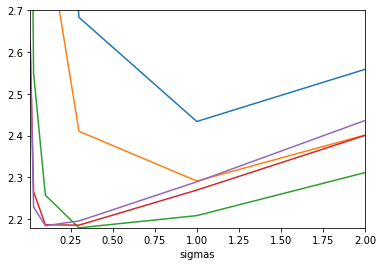

In [1659]:
fig = plt.figure()
x = sigmas
y = [test_error_np[0,:],test_error_np[1,:],test_error_np[2,:],test_error_np[3,:],test_error_np[4,:],test_error_np[5,:]]
#labels = ['\lambda = 0.95560919','\lambda = 1.46842496','\lambda = 3.71553669','\lambda = 6.83476883','\lambda = 7.86562875']
plt.xlabel("sigmas")
plt.axis([0.01,2,test_error_np.min(),2.7])
plt.plot(x, y)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
fig.savefig('sigmas.png')

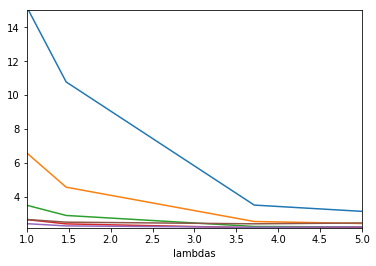

In [1661]:
fig = plt.figure()
x = lambdas
y = [test_error_np[:,0],test_error_np[:,1],test_error_np[:,2],test_error_np[:,3],test_error_np[:,4]]
labels = ['\lambda = 0.95560919','\lambda = 1.46842496','\lambda = 3.71553669','\lambda = 6.83476883','\lambda = 7.86562875']
plt.xlabel("lambdas")
plt.axis([1,5,test_error_np.min(),15])
plt.plot(x, y)
plt.show()
fig.savefig('lambdas_1.png')

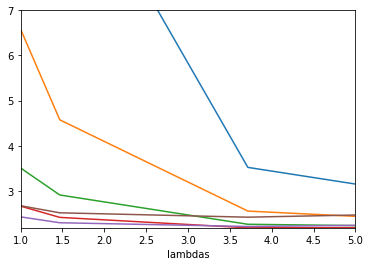

In [1662]:
fig = plt.figure()
x = lambdas
y = [test_error_np[:,0],test_error_np[:,1],test_error_np[:,2],test_error_np[:,3],test_error_np[:,4]]
labels = ['\lambda = 0.95560919','\lambda = 1.46842496','\lambda = 3.71553669','\lambda = 6.83476883','\lambda = 7.86562875']
plt.xlabel("lambdas")
plt.axis([1,5,test_error_np.min(),7])
plt.plot(x, y)
plt.show()
fig.savefig('sigmas.png')